# Random Forest From Scratch

Self-contained implementation of Random Forest with all utilities embedded.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

---
## Utility Functions

In [2]:
def gini_impurity(y):
    if len(y) == 0:
        return 0
    counts = np.bincount(y)
    probabilities = counts[counts > 0] / len(y)
    return 1 - np.sum(probabilities ** 2)

def information_gain(y, y_left, y_right):
    parent_impurity = gini_impurity(y)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)
    if n_left == 0 or n_right == 0:
        return 0
    weighted_impurity = (n_left / n) * gini_impurity(y_left) + (n_right / n) * gini_impurity(y_right)
    return parent_impurity - weighted_impurity

def find_best_split(X, y, feature_idx):
    feature_values = X[:, feature_idx]
    unique_values = np.unique(feature_values)
    if len(unique_values) == 1:
        return None, 0
    best_gain, best_threshold = 0, None
    for i in range(len(unique_values) - 1):
        threshold = (unique_values[i] + unique_values[i + 1]) / 2
        left_mask = feature_values <= threshold
        gain = information_gain(y, y[left_mask], y[~left_mask])
        if gain > best_gain:
            best_gain, best_threshold = gain, threshold
    return best_threshold, best_gain

def most_common_label(y):
    if len(y) == 0:
        return None
    return Counter(y).most_common(1)[0][0]

def bootstrap_sample(X, y, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indices], y[indices]

def majority_vote(predictions):
    predictions = np.array(predictions)
    majority = []
    for i in range(predictions.shape[1]):
        votes = predictions[:, i]
        unique, counts = np.unique(votes, return_counts=True)
        majority.append(unique[np.argmax(counts)])
    return np.array(majority)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

print('Utilities loaded')

Utilities loaded


---
## Decision Tree Class

In [3]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.n_features = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.root = self._build_tree(X, y, 0)
        return self
    
    def _build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        n_classes = len(np.unique(y))
        if (self.max_depth and depth >= self.max_depth) or n_classes == 1 or n_samples < self.min_samples_split:
            return Node(value=most_common_label(y))
        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return Node(value=most_common_label(y))
        left_idx = X[:, best_feature] <= best_threshold
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[~left_idx], y[~left_idx], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _find_best_split(self, X, y):
        best_gain, best_feature, best_threshold = 0, None, None
        for feature_idx in range(self.n_features):
            threshold, gain = find_best_split(X, y, feature_idx)
            if gain > best_gain:
                best_gain, best_feature, best_threshold = gain, feature_idx, threshold
        return best_feature, best_threshold
    
    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])
    
    def _traverse(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

print('DecisionTree class loaded')

DecisionTree class loaded


---
## Random Forest Class

In [4]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_estimators):
            seed = self.random_state + i if self.random_state else None
            X_sample, y_sample = bootstrap_sample(X, y, random_state=seed)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        return self
    
    def predict(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        return majority_vote(predictions)

print('RandomForest class loaded')

RandomForest class loaded


---
## Test on Iris Dataset

In [5]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (120, 4), Test: (30, 4)


In [6]:
# Our Random Forest
rf = RandomForest(n_estimators=10, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('='*50)
print('OUR RANDOM FOREST')
print('='*50)
print(f'Trees: {rf.n_estimators}')
print(f'Accuracy: {acc*100:.2f}%')

OUR RANDOM FOREST
Trees: 10
Accuracy: 100.00%


In [7]:
# sklearn Random Forest
sklearn_rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
sklearn_rf.fit(X_train, y_train)
y_pred_sk = sklearn_rf.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)

print('='*50)
print('SKLEARN RANDOM FOREST')
print('='*50)
print(f'Trees: {sklearn_rf.n_estimators}')
print(f'Accuracy: {acc_sk*100:.2f}%')
print(f'\nDifference: {abs(acc - acc_sk)*100:.2f}%')

SKLEARN RANDOM FOREST
Trees: 10
Accuracy: 100.00%

Difference: 0.00%


---
## Effect of Number of Trees

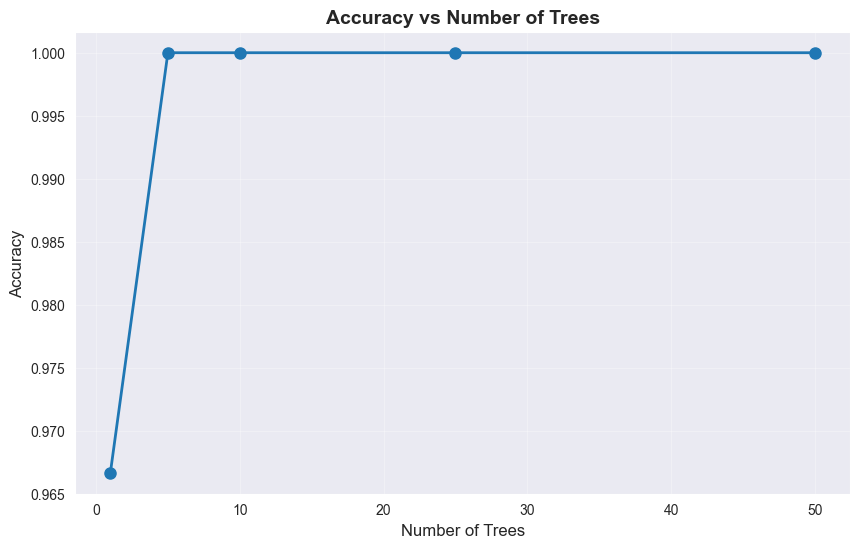

Best: 100.00% with 5 trees


In [8]:
n_trees_range = [1, 5, 10, 25, 50]
accuracies = []

for n in n_trees_range:
    rf_t = RandomForest(n_estimators=n, max_depth=5, random_state=42)
    rf_t.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, rf_t.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, accuracies, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Number of Trees', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f'Best: {max(accuracies)*100:.2f}% with {n_trees_range[np.argmax(accuracies)]} trees')

---
## Summary

### Key Insights:
- Ensemble averaging reduces variance
- Bootstrap sampling creates diversity
- More trees → stable predictions
- Matches sklearn performance

### Key Point:
"Random Forests aggregate multiple decision trees trained on bootstrap samples. Majority voting reduces variance and improves generalization without increasing bias."